In [2]:
# pip install datasets diffusers transformers
# pip install accelerate
# pip install flash-attn --no-build-isolation
# git config --global credential.helper store
# pip install -U "huggingface_hub[cli]"
# huggingface-cli login
from datasets import load_dataset, DatasetDict
from diffusers import AutoencoderKL
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, InterpolationMode
from transformers import AutoModel, AutoImageProcessor, AutoTokenizer
import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
from pathlib import Path

# ---------------- 1️⃣ Настройки ----------------
dtype = torch.float16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
img_size = 64
img_share = 0.0
empty_share = 0.01

# 1. Явно создать все необходимые директории
cache_root = Path("cache")
(cache_root/"datasets").mkdir(parents=True, exist_ok=True)
Path("datasets").mkdir(parents=True, exist_ok=True)

# 2. Установить переменные среды ПЕРЕД импортом библиотек
os.environ["HF_HOME"] = str(cache_root)
os.environ["HF_DATASETS_CACHE"] = str(cache_root/"datasets")


# ---------------- 2️⃣ Загрузка датасета ----------------
dataset = load_dataset("mnist", split="train", cache_dir=str(cache_root))

# ---------------- 3️⃣ Загрузка моделей ----------------
vae = AutoencoderKL.from_pretrained("AuraDiffusion/16ch-vae", torch_dtype=dtype).to(device).eval()
model = AutoModel.from_pretrained("visheratin/mexma-siglip", torch_dtype=dtype, trust_remote_code=True, optimized=True).to(device)
processor = AutoImageProcessor.from_pretrained("visheratin/mexma-siglip",use_fast=True)
tokenizer = AutoTokenizer.from_pretrained("visheratin/mexma-siglip")

# ---------------- 4️⃣ Трансформации ----------------
transform = Compose([
    lambda img: img.convert("RGB"), 
    Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),  # Ресайз
    ToTensor(),  # В тензор
    Normalize(mean=0.5, std=0.5)  # [-1, 1]
])

# ---------------- 5️⃣ Функция обработки изображений ----------------
def encode_images_batch(images):
    pixel_values = torch.stack([processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0) for img in images]).to(device, dtype)
    
    with torch.inference_mode():
        image_embeddings = model.vision_model(pixel_values).pooler_output #chang on last_hidden_state  # (B, 729, 1152)

    return image_embeddings.unsqueeze(1).cpu().numpy()

def encode_texts_batch(texts):
    try:
        with torch.inference_mode():
            text_tokenized = tokenizer(texts, return_tensors="pt", padding="max_length").to(device)
            features = model.text_model(
                input_ids=text_tokenized.input_ids, attention_mask=text_tokenized.attention_mask
            ).last_hidden_state
            features_proj = model.text_projector(features)
        return features_proj.cpu().numpy()
    except Exception as e:
        print(f"Ошибка при кодировании текстов: {e}")
        raise


# return empty str with prob
def maybe_empty_label(label, prob=0.01):
    return "" if random.random() < prob else label


def encode_to_latents(examples):
    pixel_values = torch.stack([transform(img) for img in examples["image"]]).to(device, dtype)  # (B, 3, 256, 256)
    
    # VAE Latents
    with torch.no_grad():
        posterior = vae.encode(pixel_values.to(device)).latent_dist.mode()
        z = (posterior - vae.config.shift_factor) * vae.config.scaling_factor
        latents = z.cpu().numpy()

    # Преобразование числовых меток в строковые
    text_labels = [str(lbl) for lbl in examples["label"]]
    
    if random.random() < img_share:
        # Image Embeddings
        pil_images = [Image.fromarray(((img.cpu().numpy().transpose(1, 2, 0) + 1) * 127.5).astype(np.uint8)) for img in pixel_values]
        embeddings = encode_images_batch(pil_images)
        #print("image_embeddings",embeddings.shape)
    else:
        text_labels_with_empty = [maybe_empty_label(lbl, empty_share) for lbl in text_labels]
        #print("text_labels_with_empty",text_labels_with_empty)
        embeddings = encode_texts_batch(text_labels_with_empty)
        #print("text_embeddings",embeddings.shape)

    return {
        "vae": latents,
        "embeddings": embeddings,
        "text": text_labels
    }

# ---------------- 6️⃣ Обработка датасета ----------------
limited_dataset = dataset#.select(range(10))#00000))  # Ограничиваем 1000 семплов
encoded_dataset = limited_dataset.map(
    encode_to_latents,
    batched=True,
    batch_size=batch_size,
    remove_columns=["image"],
    desc="Encoding images to latents"
)

# ---------------- 7️⃣ Сохранение ----------------
save_path = "datasets/mnist-te"
os.makedirs(save_path, exist_ok=True)
#encoded_dataset.to_parquet(os.path.join(save_path, "dataset.parquet"))  # Оптимальный формат
encoded_dataset.save_to_disk(save_path)
print("ok")



Encoding images to latents:   0%|          | 0/60000 [00:00<?, ? examples/s]

Saving the dataset (0/143 shards):   0%|          | 0/60000 [00:00<?, ? examples/s]

ok


Loading dataset from disk:   0%|          | 0/143 [00:00<?, ?it/s]

Форма латентного представления: (16, 8, 8)
embedding shape: (512, 1152)


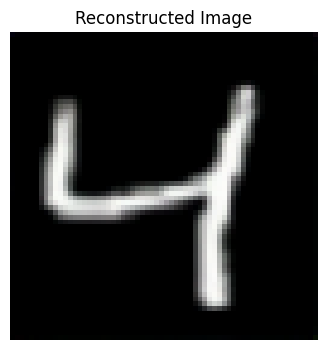

🔹 Текстовое описание: 4
ok


In [3]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image 

dtype = torch.float16

# Загружаем сохраненный датасет
loaded_dataset = load_from_disk(save_path)

# Проверяем структуру датасета
#print("Структура датасета:", loaded_dataset.features)

# Выбираем  пример для демонстрации
example = loaded_dataset[2]

# Выводим информацию о примере
print("Форма латентного представления:", np.array(example["vae"]).shape)
print("embedding shape:", np.array(example["embeddings"]).shape)

# Преобразуем латентное представление в тензор PyTorch
latent_tensor = torch.tensor(example["vae"], dtype=dtype).unsqueeze(0).to(device)

# Декодируем латентное представление обратно в изображение
with torch.no_grad():
    #reconstructed_image = vae.decode(latent_tensor).sample  # Результат — тензор
    latent = (latent_tensor.detach() / vae.config.scaling_factor) + vae.config.shift_factor
    reconstructed_image = vae.decode(latent).sample

# Переносим тензор на CPU и преобразуем в NumPy массив

reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()  # Удаляем размерность батча

# Переносим каналы в правильный формат (CHW -> HWC) и нормализуем значения пикселей
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))
reconstructed_image = (reconstructed_image + 1) / 2  # Нормализация в диапазон [0, 1]

# Преобразуем тип данных к float32
reconstructed_image = reconstructed_image.astype(np.float32)
reconstructed_image = np.clip(reconstructed_image, 0.0, 1.0)

# Отображаем восстановленное изображение
plt.figure(figsize=(4, 4))
plt.imshow(reconstructed_image)
plt.title(f"Reconstructed Image")
plt.axis("off")
plt.show()
print(f"🔹 Текстовое описание: {example['text']}")
print("ok")

In [5]:
#!pip install matplotlib

In [2]:
# Проверьте переменные окружения
hf_home = os.environ.get("HF_HOME")
hf_datasets_cache = os.environ.get("HF_DATASETS_CACHE")

if hf_home:
    print(f"HF_HOME is set to: {hf_home}")
if hf_datasets_cache:
    print(f"HF_DATASETS_CACHE is set to: {hf_datasets_cache}")

HF_HOME is set to: cache
HF_DATASETS_CACHE is set to: cache/datasets


In [3]:
print(hf_datasets_cache)

cache/datasets


In [2]:
!pip install -U transformers --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.5 MB/s eta 0:00:00


In [4]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 94.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187805408 sha256=92cf49e6f66795b6934cec0cba526ed6e45d3313de3f905d45df8773f19092a9
  Stored in directory: /root/.cache/pip/wheels/3d/88/d8/284b89f56af7d5bf366b10d6b8e251ac8a7c7bf3f04203fb4f
Successfully built flash-attn
